A --> motos
el resto coches... quiza deberiamos hacer algo distinto para las motos!!!
Hay coches amarillos que no están en el dataset, por ejemplo!

In [1]:
import tensorflow

In [92]:
from dl_model_unet import dataset
#reload(dataset)

import numpy as np
import pandas as pd

max_shape = 512
image_index = 10
test_images = 10
bsize = 5

labels_data = pd.read_csv('data/trainingObservations.csv')
data = dataset.get_labels(labels_data, {'A':'Moto', 'B':'Car', 'C':'Car', 'D':'Car', 'E':'Car', 'F':'Car', 'G':'Car', 'H':'Car', 'I':'Car'})    

cases = list(data.keys())
np.random.shuffle(cases)
train_cases, test_cases = cases[test_images:], cases[:test_images]
train_generator = dataset.chunk(train_cases, data, bsize, max_shape)
test_generator = dataset.chunk(test_cases, data, bsize, max_shape)

#for x,y in train_generator:
#    print x.shape, y.shape

In [ ]:
from keras.optimizers import Adam
from dl_networks import unet
import keras.backend as K
from keras import backend as K


def max_pred(y_true, y_pred):
    return K.max(y_pred)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


model = unet.ThickUNET(input_shape=(3,max_shape,max_shape), activation='relu').model
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=['accuracy',max_pred])
# logging.info('Loading exiting model...')
# model.load_weights(OUTPUT_MODEL)



In [ ]:
model.fit_generator(
                    generator=train_generator,
                    samples_per_epoch=50,  # make it small to update TB and CHECKPOINT frequently
                    nb_epoch=3000,
                    verbose=1,
                    #class_weight={0:1., 1:4.},
                    #callbacks=[tb, model_checkpoint],
                    validation_data=test_generator,  # TODO: is_training=False
                    nb_val_samples=2,
                    max_q_size=30,
                    nb_worker=1)  # a locker is needed if increased the number of parallel workers



In [ ]:
import pylab
from pylab import *
from scipy.signal import convolve2d


%matplotlib inline
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

for x,y in test_generator:
    preds = model.predict(x)
    
    for i in range(len(preds)):
        figure()
        imshow(x[i].transpose([1,2,0]))
        figure()

        aux = convolve2d(preds[i][0], np.ones([5,5]), mode = 'same')
        aux = (aux - aux.min()) / (aux.max() - aux.min())
        imshow(aux[5:-5,5:-5] * (aux[5:-5,5:-5] > 0), cmap = cm.Greens)
        imshow(y[i][0][5:-5,5:-5], cmap = pylab.cm.Reds, alpha = 0.1)

    break

# playing with OpenCV

In [ ]:
import cv2
img = cv2.imread('data/training/' + train_cases[0] + '.jpg', 0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
imshow(np.asarray(res))



In [ ]:
import numpy as np
import cv2

im = cv2.imread('data/training/' + train_cases[1] + '.jpg')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
thresh = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,51, 5)

contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(im, contours, -1, (0,255,100), 1)
imshow(im, cmap=cm.Greys)


In [ ]:
cv2.adaptiveThreshold?

In [ ]:
cv2.threshold?

## KNN

In [3]:
labels_data = pd.read_csv('data/trainingObservations.csv')
data = dataset.get_labels(labels_data, {'A':'Moto', 'B':'Car', 'C':'Car', 'D':'Car', 'E':'Car', 'F':'Car', 'G':'Car', 'H':'Car', 'I':'Car'})    

In [105]:
data_to_load = 'TQ2379_0_0'
coords = data[data_to_load]['Car']
im = dataset.load_image(data_to_load)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


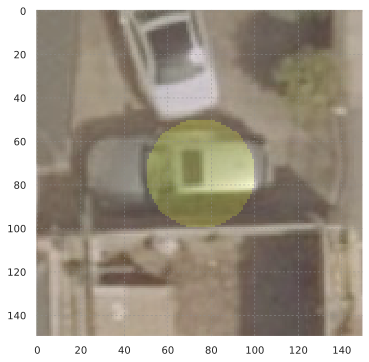

In [115]:
x, y = np.indices((im.shape[0], im.shape[0]))
x1, y1, x2, y2 = coords[0][1], coords[0][0], coords[1][1], coords[1][0]
r1, r2 = 25, 25
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2)

figure();
imshow(im[x1-75:x1+75,y1-75:y1+75])
imshow(mask[x1-75:x1+75,y1-75:y1+75], alpha = 0.4)


In [119]:
import scipy.misc
import cv2
lenna = im[x1-75:x1+75,y1-75:y1+75]
lenna = cv2.Image(scipy.misc.toimage(lenna))


peaks = lenna.huePeaks()
peak_one = peaks[0][0]
hue = lenna.hueDistance(peak_one)
hue.show()


ModuleNotFoundError: No module named 'cv2'

/home/joseal/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/home/joseal/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/home/joseal/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/home/joseal/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/home/joseal/.lo

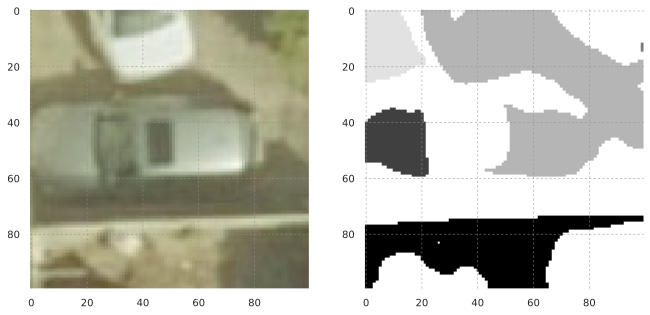

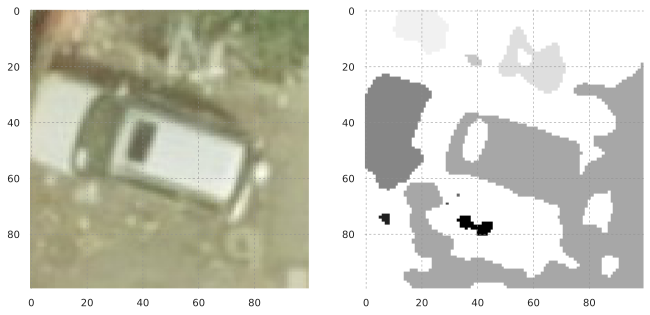

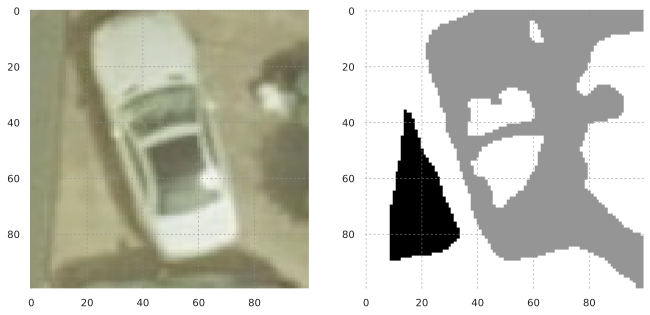

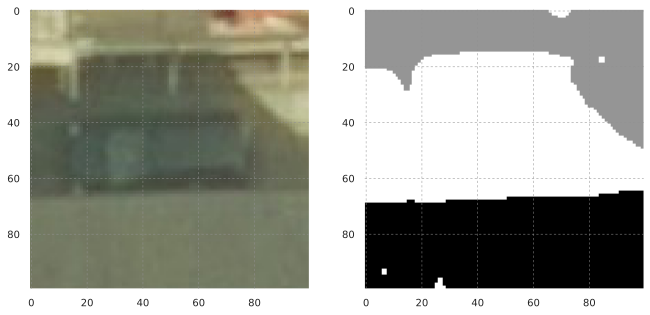

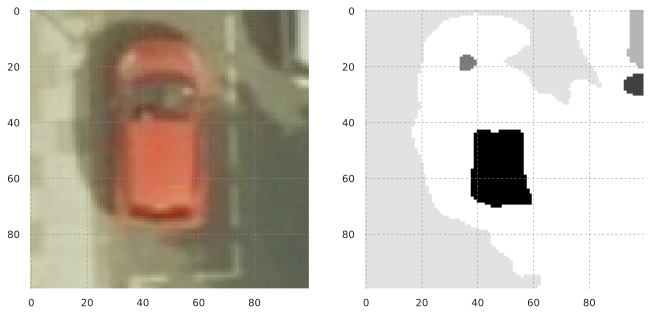

In [99]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from skimage import filters
from pylab import *

def show_segmentation(car):
    dbs = KMeans(n_clusters=5)
    s = dbs.fit_predict(car.reshape([100*100,3]))
    figure()
    subplot(121); imshow(s.reshape([100,100]))
    subplot(122); imshow(car)

def show_segmentation_2(car):
    img = car.mean(axis=2)
    im = filters.gaussian_filter(img, sigma=l / (4. * 3))
    blobs = im > im.mean()
    from skimage import measure
    blobs_labels = measure.label(blobs)
    figure(); subplot(121); imshow(car, cmap = cm.Greys); subplot(122); imshow(blobs_labels, cmap = cm.Greys)

data_to_load = 'TQ2379_0_0'
coords = data[data_to_load]['Car']
im = dataset.load_image(data_to_load)    

for coords_i in range(len(coords)):
    car = im[coords[coords_i][1]-50:coords[coords_i][1]+50,coords[coords_i][0]-50:coords[coords_i][0]+50]
    show_segmentation_2(car)

In [87]:
from skimage import filters
#img = car.mean(axis=2)
#val = filters.threshold_otsu(img)
#mask = img < val
#img *= mask

#val = filters.threshold_otsu(img)
#mask = img < val
#img *= mask


#figure(); imshow(img, cmap = cm.Greys)
def segmentation2(car):
    img = car.mean(axis=2)
    im = filters.gaussian_filter(img, sigma=l / (4. * 1))
    blobs = im > im.mean()
    from skimage import measure
    blobs_labels = measure.label(blobs)
    figure(); subplot(121); imshow(car, cmap = cm.Greys); subplot(122); imshow(blobs_labels, cmap = cm.Greys)


In [83]:
blobs_labels.max()

0

In [ ]:

dbs = DBSCAN

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


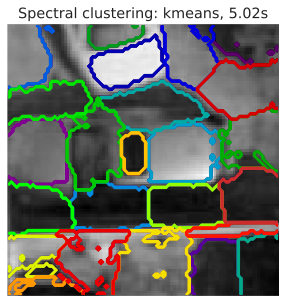

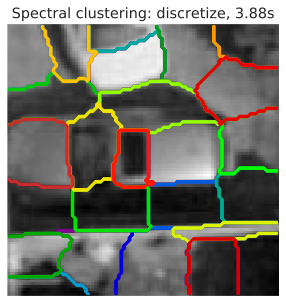

In [29]:
import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

# Downsample the image by a factor of 4
lena= car.mean(axis=2)  #### blanco y negro por si acaso
# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(lena)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / lena.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

###############################################################################
# Visualize the resulting regions

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels,
                                 random_state=1)
    t1 = time.time()
    labels = labels.reshape(lena.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(lena,   cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0)))

plt.show()


In [19]:
image.img_to_graph?

In [26]:
lena.shape

(3, 100, 100)